In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom import DiscreteValuedOOM
from src.oom.observable import *

sys.modules['oom'] = oom

In [3]:
import pickle
import os

import numpy as np

In [4]:
with open(os.path.abspath('../data/learned_5_50.pickle'), 'rb') as picklefile:
    myoom = pickle.load(picklefile)

## Generation

In [7]:
try:
    gen = myoom.generate(1000)
except ValueError:
    print("Values do not sum to 1.")

Values do not sum to 1.


## Validating Observable Operator Models

By "validating", I mean both checking the conditions a Stochastic System (SS) needs to fulfill in order to be an OOM of a valid stochastic process, as defined in [1]. By taking the system function definition and writing out its explicit definition in terms of the SS tuple's linear algebraic items, I propose two independent and sequential normalization steps, for the starting state and the operator matrices. The terms of the normalization are not necessarily these, and it is still debatable which term should not be affected by a normalization procedure.

### 1. Start state: <span style="color: #DDBBFF"> $\displaystyle f(\varepsilon) = 1 \Longleftrightarrow \sigma \omega_\varepsilon = 1 $ </span>

We can normalize the starting state vector $\displaystyle \omega_\varepsilon $ to achieve this result by $\displaystyle \omega_\varepsilon \leftarrow \omega_\varepsilon \frac{1}{\sigma \omega_\varepsilon}$.

##### a. Check actual values

In [8]:
print(myoom.lin_func * myoom.start_state)

[[0.99998611]]


##### b. Apply normalization

In [9]:
err = myoom.lin_func * myoom.start_state
myoom.start_state /= err

##### c. Check updated values

In [10]:
print(myoom.lin_func * myoom.start_state)

[[1.]]


### 2. Future distribution: <span style="color: #DDBBFF"> $\displaystyle \forall\; \bar{x} \in \Sigma^*,\; f(\bar{x}) = \sum_{x \in \Sigma} f(\bar{x} x) \Longleftrightarrow \sigma \tau_\bar{x} \omega_\varepsilon = \sigma \left(\sum_{x \in \Sigma} \tau_x \right) \tau_\bar{x} \omega_\varepsilon $ </span>

Since we want the previous relation to hold with $\displaystyle \tau_\bar{x} $ for all $\displaystyle \bar{x} \in \Sigma^* $, this amounts to having $\displaystyle \sigma = \sigma \left(\sum_{x \in \Sigma} \tau_x \right) $.

We can normalize the operator matrices $\displaystyle \tau_x $ to achieve this result by $\displaystyle [\tau_x]_j \leftarrow [\tau_x]_j \frac{[\sigma]_j}{\sigma [\mu]_j}$, where $\displaystyle \mu \equiv \sum_{x \in \Sigma} \tau_x $ and the notation $\displaystyle [M]_j$ denotes the $j$-th column of the matrix $M$.

##### a. Check actual values

In [11]:
print(myoom.lin_func * sum([op.mat for op in myoom.operators]))
print(myoom.lin_func)

[[ 1.99474191  0.1339109  -0.02175702  0.04968667  0.02613801]]
[[ 1.99482254  0.14450773 -0.00714955  0.01210436  0.01103387]]


##### b. Apply normalization

In [12]:
mu = sum([op.mat for op in myoom.operators])

for op in myoom.operators:
    lin_func_err = myoom.lin_func * mu
    
    for col in range(op.mat.shape[1]):
        op.mat[:, col] = op.mat[:, col] * myoom.lin_func[0, col] / lin_func_err[0, col]

##### c. Check updated values

In [13]:
print(myoom.lin_func * sum([op.mat for op in myoom.operators]))
print(myoom.lin_func)

[[ 1.99482254  0.14450773 -0.00714955  0.01210436  0.01103387]]
[[ 1.99482254  0.14450773 -0.00714955  0.01210436  0.01103387]]


# Generation (again)

In [121]:
try:
    gen, seq, pro = myoom.generate(10000)
    print(seq[:10])
except ValueError:
    print("Values do not sum to 1.")

OeOaOeOcOdOcOeOaOcOe


## Assessment

In [276]:
learnedoom = DiscreteValuedOOM.from_data(
    obs = seq,
    target_dimension = 15,
    memory_limit_mb = 0.9
)

155 char. words, 155 ind. words
(0, Oa) (10, ObOa) (20, OdOa) (30, OaOaOa) (40, OaOcOa) (50, OaOeOa) (60, ObObOa) (70, ObOdOa) (80, OcOaOa) (90, OcOcOa) (100, OcOeOa) (110, OdObOa) (120, OdOdOa) (130, OeOaOa) (140, OeOcOa) (150, OeOeOa) 

In [277]:
myoom.lf_on_operators * myoom.start_state

matrix([[0.19611293],
        [0.18763182],
        [0.23371291],
        [0.18909258],
        [0.19344976]])

In [278]:
learnedoom.lf_on_operators * learnedoom.start_state

matrix([[0.19459979],
        [0.18667467],
        [0.23588245],
        [0.19084597],
        [0.19199712]])

In [279]:
def cross_entropy(p, q):
    _ewp = np.prod([p, np.log(q)], axis = 0)
    _ce = -np.sum(_ewp, axis = -1)
    return _ce

def kl_divergence(p, q):
    _ewp = np.prod([p, np.log(np.divide(p, q))], axis = 0)
    _kl = np.sum(_ewp, axis = -1)
    return _kl

ce_arr = []
kl_arr = []
for n_iter in range(1000):
    sg, og, pg = myoom.generate(31)
    sl, ol, pl = learnedoom.generate(31)
    
    ce_arr.append(cross_entropy(pg, pl))

In [280]:
ce_arr_mean = np.mean(ce_arr, axis = 0)
ce_arr_std = np.std(ce_arr, axis = 0)

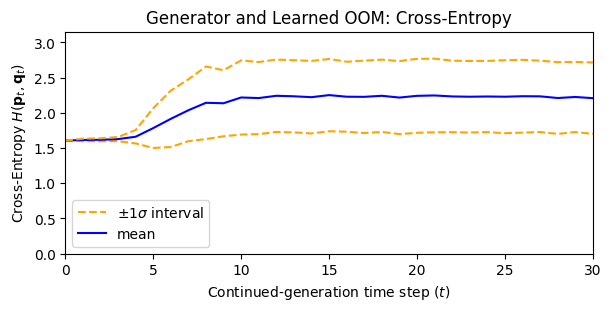

In [281]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(layout="constrained", figsize = (6, 3))
ax.plot(ce_arr_mean - ce_arr_std, c = 'orange', ls = '--', label = r"$\pm 1\sigma$ interval")
ax.plot(ce_arr_mean, c = 'blue', label = "mean")
ax.plot(ce_arr_mean + ce_arr_std, c = 'orange', ls = '--')
ax.set_xlim([0, len(ce_arr_mean)-1])
ax.set_ylim([0, 1.4 * max(ce_arr_mean)])
ax.set_title("Generator and Learned OOM: Cross-Entropy")
ax.set_xlabel("Continued-generation time step ($t$)")
ax.set_ylabel(r"Cross-Entropy $H(\mathbf{p}_t, \mathbf{q}_t)$")
ax.legend()
plt.savefig("crossentropy_350.pdf")
plt.show()